In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pk
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
data_file_1_name = 'data/AlarmLogExport-20180622-145808.CSV'
data_file_2_name = 'data/AlarmLogExport-20180622-145852.CSV'

# alarm ID 不能够以浮点数的形式读入，显式指明为字符串
data_type = str

In [3]:
data1 = pd.read_csv(
    data_file_1_name,
    header=0,
    dtype=data_type
    )
data1.rename(columns={'告警ID':'Alarm_ID', '告警级别':'Alarm_Level', '告警名称':'Alarm_name','告警对象':'Alarm_Object', '对象类型':'Object_Class', '产生时间':'G_Time', '清除时间':'Clean_Time', '清除类型':'Clean_Class'}, inplace = True)
# data1.describe()
data1.tail()
# data1.shape

,Alarm_ID,Alarm_Level,Alarm_name,Alarm_Object,Object_Class,G_Time,Clean_Time,Clean_Class
6012,15.1000103,重要,虚拟机磁盘占用率超过阈值,VW07-132-98-0-135,虚拟机,2017-11-17 18:51:00 UTC+08:00,2018-06-02 03:49:00 UTC+08:00,正常清除
6013,15.1000103,重要,虚拟机磁盘占用率超过阈值,VW07-132-98-0-129,虚拟机,2017-11-17 18:03:00 UTC+08:00,2018-06-01 13:12:00 UTC+08:00,正常清除
6014,15.1000103,次要,虚拟机磁盘占用率超过阈值,VW07-132-98-0-122,虚拟机,2017-11-17 04:21:00 UTC+08:00,2018-06-12 21:20:00 UTC+08:00,正常清除
6015,15.1000103,重要,虚拟机磁盘占用率超过阈值,VW07-132-98-0-128,虚拟机,2017-11-16 15:43:00 UTC+08:00,2018-05-29 17:24:00 UTC+08:00,正常清除
6016,15.1000103,重要,虚拟机磁盘占用率超过阈值,VW07-132-98-0-90,虚拟机,2017-08-29 08:30:00 UTC+08:00,2018-06-02 02:06:00 UTC+08:00,正常清除


## 1. 准备训练数据
1. 为每一种告警，生成一个唯一的索引index，并且使用一个类`AlarmSummary`（类似于以前看到了那一个Lang类一样），该类维护这些数据
    1. index2id -> dict：使用唯一的索引index得到对应的alarm_id
    2. id2index -> dict：使用告警的id，得到对应的唯一的索引index
    3. alarm_num -> int: 记录目前告警的数量
    4. id2full -> dict : 得到告警的详细信息
2. 将告警日志按照时间进行排序，并进行适当的简化
    1. 只有一列， 按照时间先后顺序排序的事件id list

### 1.1 AlarmSummary类

In [4]:
class AlarmSummary():
    def __init__(self, name):
        self.name = name
        self.index2id = {}
        self.id2index = {}
        self.id2full = {}
        self.alarm_num = 0
    def addAlarm(self, alarm_id, alarm_level, alarm_content):
        '''
        add a new alarm type
        '''
        if alarm_id not in self.id2full.keys():
            new_index = self.alarm_num+1
            self.id2full[alarm_id] = {
                'level':alarm_level,
                'content':alarm_content,
                'index':new_index
            }
            self.index2id[new_index] = alarm_id
            self.id2index[alarm_id] = new_index
            
            self.alarm_num += 1
    def get_index(self, alarm_id):
        return self.id2index[alarm_id]

In [5]:
bare_id = data1.iloc[:,0:3]
alarm_id_column_name = bare_id.columns[0]
# 获取第一列的索引值，并以此列进行去重,去重后按照id排序
bare_ids = bare_id.drop_duplicates(alarm_id_column_name, keep='last').sort_values(by=alarm_id_column_name)

this_alarm_summary = AlarmSummary(data_file_1_name)

# 将目前的数据集中的告警信息加入到类中
for index, row in bare_ids.iterrows():
    this_alarm_summary.addAlarm(row[0], row[1], row[2])

print(this_alarm_summary.index2id, this_alarm_summary.id2index, this_alarm_summary.id2full)

# 结果：this_alarm_summary

{1: '15.1000020', 2: '15.1000032', 3: '15.1000036', 4: '15.1000101', 5: '15.1000102', 6: '15.1000103', 7: '15.1002006', 8: '15.1004005', 9: '15.1004014', 10: '15.1005003', 11: '15.1005007', 12: '15.1006000', 13: '15.1006001', 14: '15.1006008', 15: '15.1008002', 16: '15.1008005', 17: '15.1008007'} {'15.1000020': 1, '15.1000032': 2, '15.1000036': 3, '15.1000101': 4, '15.1000102': 5, '15.1000103': 6, '15.1002006': 7, '15.1004005': 8, '15.1004014': 9, '15.1005003': 10, '15.1005007': 11, '15.1006000': 12, '15.1006001': 13, '15.1006008': 14, '15.1008002': 15, '15.1008005': 16, '15.1008007': 17} {'15.1000020': {'level': '重要', 'content': '内存预留率超过阈值', 'index': 1}, '15.1000032': {'level': '次要', 'content': '主机CPU占用率超过阈值', 'index': 2}, '15.1000036': {'level': '次要', 'content': '主机逻辑磁盘占用率超过阈值', 'index': 3}, '15.1000101': {'level': '重要', 'content': '虚拟机CPU占用率超过阈值', 'index': 4}, '15.1000102': {'level': '重要', 'content': '虚拟机内存占用率超过阈值', 'index': 5}, '15.1000103': {'level': '重要', 'content': '虚拟机磁盘占用率超过阈值

In [6]:
this_alarm_summary.id2full

{'15.1000020': {'level': '重要', 'content': '内存预留率超过阈值', 'index': 1},
 '15.1000032': {'level': '次要', 'content': '主机CPU占用率超过阈值', 'index': 2},
 '15.1000036': {'level': '次要', 'content': '主机逻辑磁盘占用率超过阈值', 'index': 3},
 '15.1000101': {'level': '重要', 'content': '虚拟机CPU占用率超过阈值', 'index': 4},
 '15.1000102': {'level': '重要', 'content': '虚拟机内存占用率超过阈值', 'index': 5},
 '15.1000103': {'level': '重要', 'content': '虚拟机磁盘占用率超过阈值', 'index': 6},
 '15.1002006': {'level': '紧急', 'content': '主机与NTP服务器心跳状态异常', 'index': 7},
 '15.1004005': {'level': '紧急', 'content': '虚拟机发生蓝屏故障', 'index': 8},
 '15.1004014': {'level': '重要', 'content': 'Libvirt管理端口认证未开启', 'index': 9},
 '15.1005003': {'level': '重要', 'content': '存储使用容量超过阈值', 'index': 10},
 '15.1005007': {'level': '提示', 'content': '数据存储I/O响应时延超过阈值', 'index': 11},
 '15.1006000': {'level': '紧急', 'content': '虚拟机发生反复重启故障', 'index': 12},
 '15.1006001': {'level': '重要',
  'content': '网口自协商速率没有达到服务器网口的最大速率',
  'index': 13},
 '15.1006008': {'level': '提示', 'content': '主机管理接口未配置网络冗余'

### 1.2 准备数据
最终得到一个由事件id组成的序列

In [7]:
time_column_name = data1.columns[5]
# time_column_name
# 得到排序后的一列
alarm_id_list = list(data1.sort_values(by=time_column_name)[alarm_id_column_name])
alarm_id_list[:10]

['15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000102',
 '15.1000103',
 '15.1000103',
 '15.1000103',
 '15.1000103']

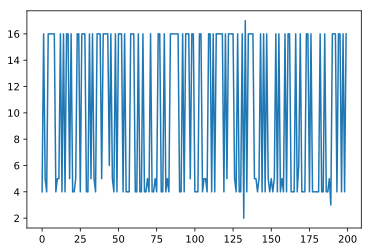

In [8]:
alarm_index_list = [this_alarm_summary.get_index(i) for i in alarm_id_list]
alarm_index_list
with open('data/alarm_index_list.pk', 'wb') as f:
    pk.dump(alarm_index_list, f)
plt.plot(alarm_index_list[1000:1200])

## 2 进一步处理数据

在这些方面，我需要对数据进行进一步处理：
1. 在不同的维度，对数据进行分类
    1. 对于告警，有的告警是针对主机的，而有的告警是针对虚拟机的，同时，即使是同一类的告警，也可能是发生在不同的主机上，或者不同的虚拟机上，需要区分。

In [9]:
data1[ ( data1['Object_Class'] == '虚拟机' ) & ( data1['Alarm_Object'] == 'VW07-132-98-0-52' ) ][:20]

,Alarm_ID,Alarm_Level,Alarm_name,Alarm_Object,Object_Class,G_Time,Clean_Time,Clean_Class
4,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-20 17:32:00 UTC+08:00,-,-
1434,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-13 11:08:00 UTC+08:00,2018-06-18 13:12:00 UTC+08:00,正常清除
1696,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-12 10:17:00 UTC+08:00,2018-06-12 15:06:00 UTC+08:00,正常清除
2694,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-08 09:53:00 UTC+08:00,2018-06-12 06:19:00 UTC+08:00,正常清除
3181,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-05 06:16:00 UTC+08:00,2018-06-07 18:37:00 UTC+08:00,正常清除
3726,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-06-01 08:32:00 UTC+08:00,2018-06-02 02:55:00 UTC+08:00,正常清除
4184,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-30 10:29:00 UTC+08:00,2018-06-01 06:08:00 UTC+08:00,正常清除
4904,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-25 15:37:00 UTC+08:00,2018-05-29 09:30:00 UTC+08:00,正常清除
4912,15.1000102,重要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-25 14:42:00 UTC+08:00,2018-05-25 14:49:00 UTC+08:00,正常清除
5345,15.1000102,次要,虚拟机内存占用率超过阈值,VW07-132-98-0-52,虚拟机,2018-05-21 10:07:00 UTC+08:00,2018-05-25 14:34:00 UTC+08:00,正常清除


In [10]:
# 告警对象筛选器，筛选出主机和虚拟机
alarm_object = data1[~data1.duplicated('Alarm_Object')]
vm_alarm_object_names = alarm_object[alarm_object['Object_Class'] == '虚拟机']['Alarm_Object']
pc_alarm_object_names = alarm_object[alarm_object['Object_Class'] == '主机']['Alarm_Object']

## 2.1 对象告警信息筛选并加上时间戳
我想写一个函数，输入是告警对象，输出是该对象的情况。
该对象的情况，应该是这样的一个数据
一列是时间戳，另一列是该对象的状况（正常，或某告警ID）

### 2.1.1 得到时间戳

In [11]:
import time
def getTimeStamp(time_name):
    """
    时间格式：2018-05-16 05:41:00 UTC+08:00
    转为：float
    """
    time_names = time_name.split(' ')
    format_time = time_names[0] + ' ' + time_names[1]
    timestamp = int(time.mktime(time.strptime(format_time,'%Y-%m-%d %H:%M:%S')))
    timestamp  = int(timestamp/60)
    return timestamp

In [12]:
def get_vm_status(full_data, vm_name):
    """
    从data1里找到该对象的告警信息，弄成一个列表
    1. 时间，告警
    2. 时间戳，告警id
    """
#     得到该指定对象的数据
    object_data = full_data[full_data['Alarm_Object'] == vm_name]
#     取出告警ID和产生时间两列
    object_data = object_data[['Alarm_ID','G_Time']]
#     产生时间一列转换为时间戳
    object_data['G_Time'] = object_data['G_Time'].apply(getTimeStamp)
    object_data['Alarm_ID'] = object_data['Alarm_ID'].apply(this_alarm_summary.get_index)
    return object_data

In [13]:
get_vm_status(data1, 'VW07-132-98-0-91')

,Alarm_ID,G_Time
1546,8,25480231
1611,4,25479925
1740,4,25479211


## 2.2 寻找信息较多的告警对象
1. 得到虚拟机可用对象列表
2. 对所有对象进行遍历，寻找告警数量较多的对象
3. 得到几十个可用于训练的虚拟机对象,主机对象

### 2.2.1 虚拟机可用对象列表

In [14]:
vm_alarm_object_names = list(vm_alarm_object_names)
vm_alarm_object_names[:10]

['VW07-132-98-0-54',
 'VW07-132-98-0-111',
 'VW07-132-98-0-52',
 'VW07-132-98-0-67',
 'VW07-132-98-0-70',
 'VW07-132-98-0-85',
 'VW07-132-98-0-84',
 'VLR-10-123-200-38',
 'VL-123-200-110',
 'VLR_10.123.200.37_1']

### 2.2.2 遍历虚拟机对象，寻找告警数量较多的对象

In [15]:
vm_alarm_nums = {}
for vm_name in vm_alarm_object_names:
    vm_status = get_vm_status(data1, vm_name)
    vm_alarm_nums[vm_name] = len(vm_status)

In [16]:
max_alarm_vms = sorted(vm_alarm_nums.items(), key=lambda item:item[1])
max_alarm_vms = max_alarm_vms[-30:]
max_alarm_vms

[('VW07-132-98-0-128', 10),
 ('VLR-10-123-197-37', 13),
 ('VW07-132-98-0-52', 14),
 ('VLR_10.123.200.37_1', 14),
 ('VW07-132-98-0-129', 15),
 ('VW07-132-98-0-137', 15),
 ('VW07-132-98-0-51', 19),
 ('VW07-132-98-0-84', 20),
 ('VW07-132-98-0-165', 20),
 ('VLR-10-123-200-40', 22),
 ('VW07-132-98-0-88', 30),
 ('VW07-132-98-0-168', 30),
 ('VLS-192-168-130-145', 30),
 ('VLR-10-123-197-42', 35),
 ('VL-123-200-110', 37),
 ('VLR-10-123-197-40', 37),
 ('VW07-132-98-0-67', 41),
 ('VW07-132-98-0-111', 45),
 ('VW07-132-98-0-70', 51),
 ('VLR-10-123-200-41', 68),
 ('VLR-10-123-197-15', 89),
 ('VLR-10-123-200-38', 139),
 ('VW07-132-98-0-53', 194),
 ('VW07-132-98-0-159', 211),
 ('VL-123-200-106', 211),
 ('VW07-132-98-0-153', 263),
 ('VW07-132-98-0-161', 288),
 ('VW07-132-98-0-59', 299),
 ('VW07-132-98-0-83', 532),
 ('VW07-132-98-0-54', 858)]

In [17]:
max_alarm_vm_names = [ name[0] for name in max_alarm_vms]
max_alarm_vm_names

['VW07-132-98-0-128',
 'VLR-10-123-197-37',
 'VW07-132-98-0-52',
 'VLR_10.123.200.37_1',
 'VW07-132-98-0-129',
 'VW07-132-98-0-137',
 'VW07-132-98-0-51',
 'VW07-132-98-0-84',
 'VW07-132-98-0-165',
 'VLR-10-123-200-40',
 'VW07-132-98-0-88',
 'VW07-132-98-0-168',
 'VLS-192-168-130-145',
 'VLR-10-123-197-42',
 'VL-123-200-110',
 'VLR-10-123-197-40',
 'VW07-132-98-0-67',
 'VW07-132-98-0-111',
 'VW07-132-98-0-70',
 'VLR-10-123-200-41',
 'VLR-10-123-197-15',
 'VLR-10-123-200-38',
 'VW07-132-98-0-53',
 'VW07-132-98-0-159',
 'VL-123-200-106',
 'VW07-132-98-0-153',
 'VW07-132-98-0-161',
 'VW07-132-98-0-59',
 'VW07-132-98-0-83',
 'VW07-132-98-0-54']

### 2.2.3 类似的，找主机

## 2.3 准备数据

我要给我的模型喂怎样的数据？
一个具有等长时间间隔的，事件id序列，序列的长度可以不定。
需要有这样的一个列表，列表中的每一项都是一个事件序列

In [18]:
train_data_lists = [ get_vm_status(data1, name) for name in max_alarm_vm_names ]

In [19]:
for vm_alarm_data in train_data_lists:
    alarm_ids = list(vm_alarm_data['Alarm_ID'])    

In [20]:
train_data_lists[0][:10]

,Alarm_ID,G_Time
49,6,25469495
1703,5,25479461
2904,5,25472286
2910,5,25472246
3679,6,25463875
4322,6,25459767
5109,5,25451025
5222,5,25449307
5978,5,25432328
6015,6,25180303


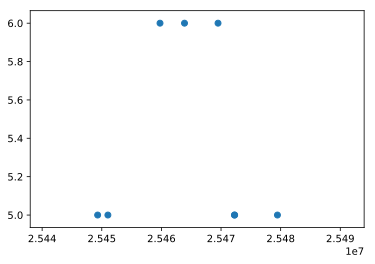

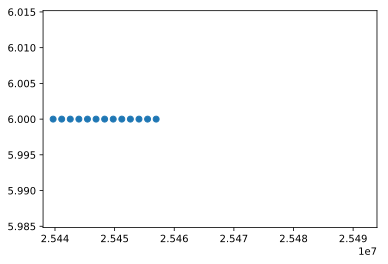

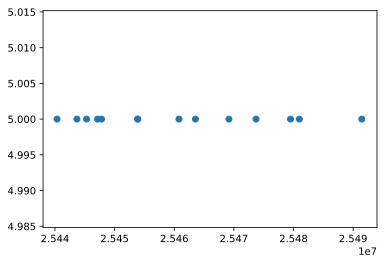

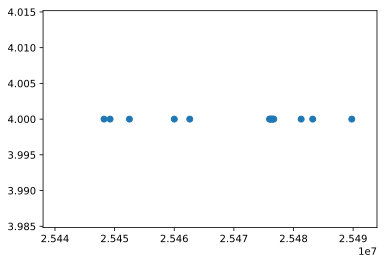

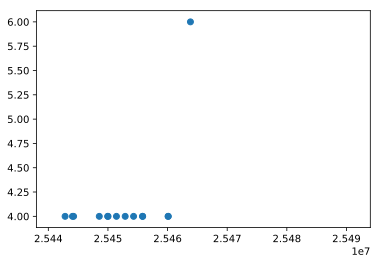

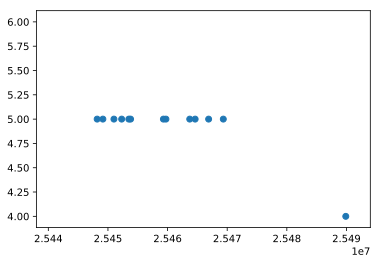

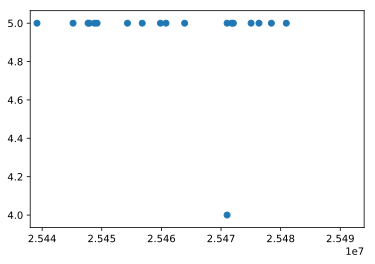

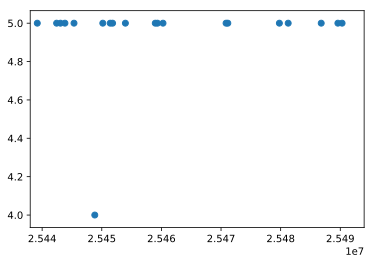

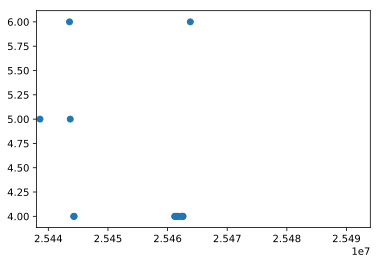

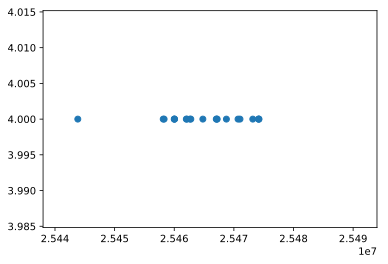

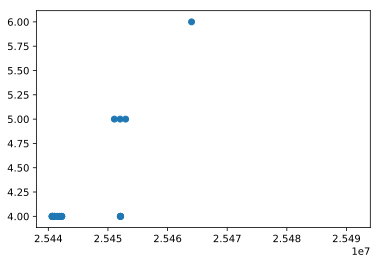

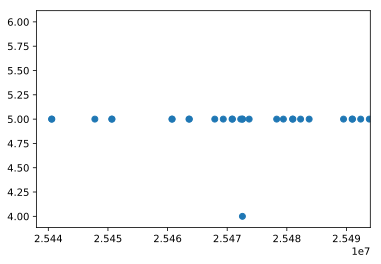

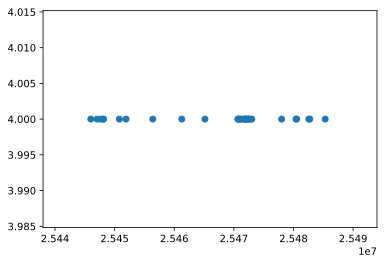

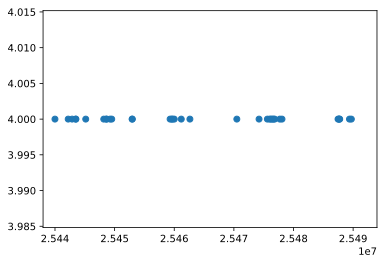

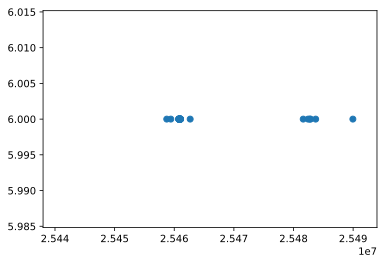

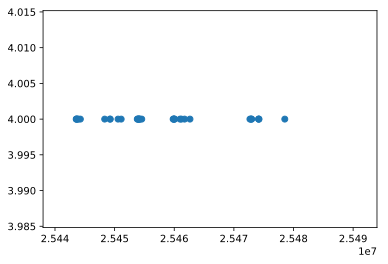

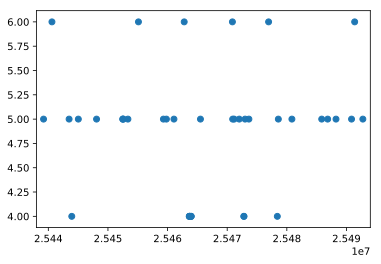

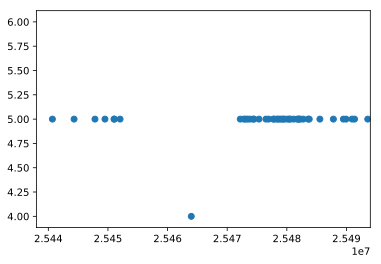

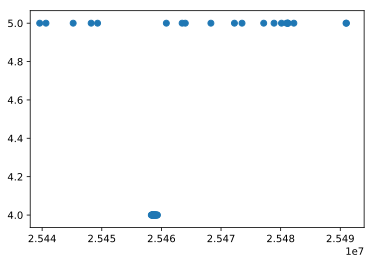

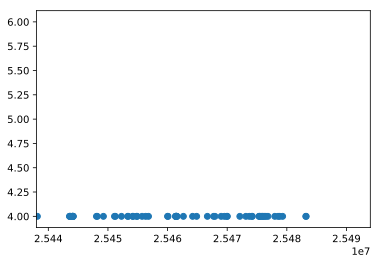

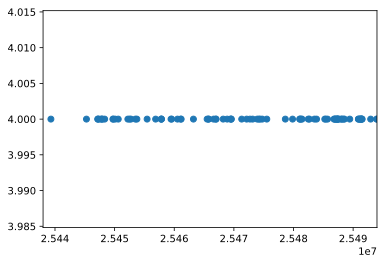

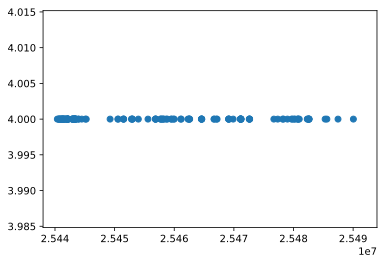

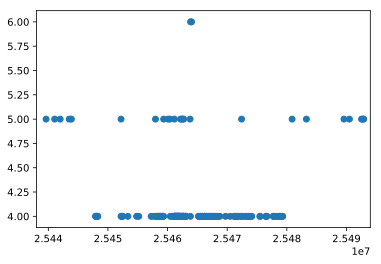

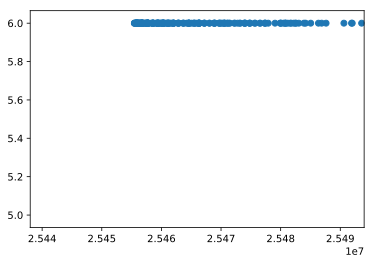

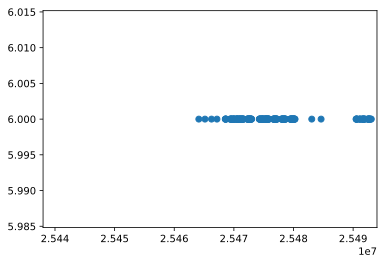

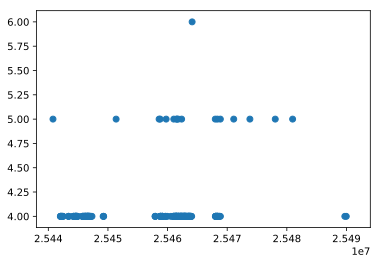

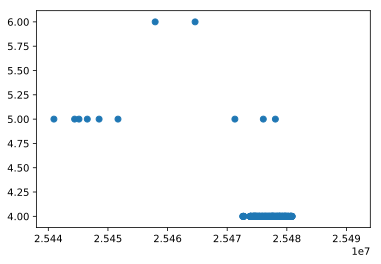

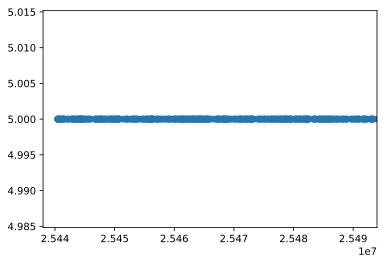

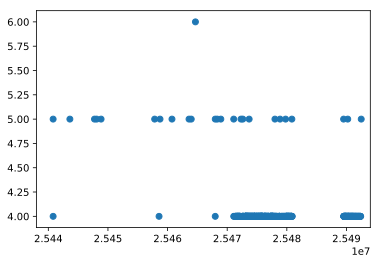

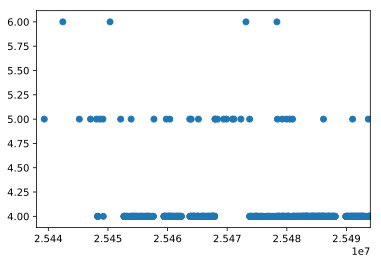

In [21]:
min_time = 25438000
max_time = 25494000
for vm_data in train_data_lists:
    plt.xlim((min_time, max_time))
    plt.scatter(vm_data['G_Time'], vm_data['Alarm_ID'])
    plt.show()

可以发现，这些数据存在以下几个特点
1. 虚拟机的告警，集中在三种（CPU，内存，磁盘）中，以后整理数据，可考虑只进行这三种告警的预测，将其他告警去除
2. 时间集中在(254.38e5, 254.94e5)中，考虑将其他时间范围的告警数据去除，只保留这个时间段的数据，并增加“正常状态”
3. 之前已经将数据整理成以分钟为单位，此后的预测迭代也将以分钟作为单位来进行预测

考虑将数据继续整理。
1. 只保留指定时间内的告警
1. 以分钟为单位，每一分钟报告一个状态，原来没有告警的分钟都设置为正常（id：0）
1. 去除多余的告警，只保留4,5,6三种告警

In [22]:

vm_full_status_lists = []
for vm_data in train_data_lists:
    # 这是一个具有时间戳和对应时间的表格
#   去除其余时间的告警
    vm_data = vm_data[(vm_data['G_Time'] > min_time) & (vm_data['G_Time'] <= max_time)]
#     去除其他类型的告警
    vm_data = vm_data[(vm_data['Alarm_ID'] == 4)|(vm_data['Alarm_ID'] == 5)|(vm_data['Alarm_ID'] == 6)]
#     对每个时间戳明确状态，增加正常状态
    vm_full_status_list = []
    for i in range(max_time - min_time+1):
        vm_full_status_list.append(0)
    for g_time, alarm_id in zip(list(vm_data['G_Time']),list(vm_data['Alarm_ID'])):
        vm_full_status_list[g_time-min_time] = alarm_id
    vm_full_status_lists.append(vm_full_status_list)

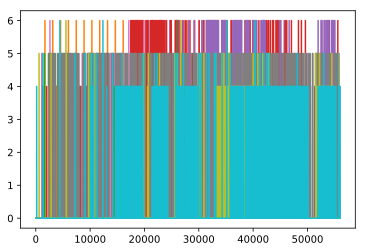

In [23]:
for vm_full_status_list in vm_full_status_lists:
    plt.plot(vm_full_status_list)

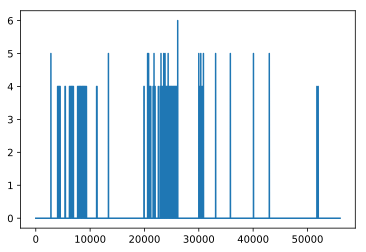

In [24]:
plt.plot(vm_full_status_lists[25])

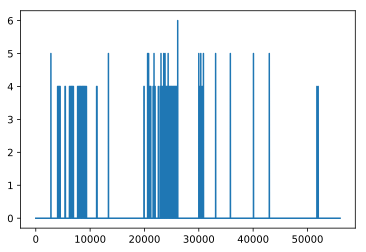

In [25]:
dataset_np = []
for vm_data in vm_full_status_lists:
    dataset_np.append(np.array(vm_data))
dataset_np[25]
plt.plot(dataset_np[25])

## 3 准备模型

这时候我已经有了这样的一个事件序列，我的模型是怎样的？

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

HIDDEN_SIZE = 51
TRAIN_SAMPLE_NUM = 25
TEST_SAMPLE_NUM = 5

ModuleNotFoundError: No module named 'torch'

In [30]:
class LstmPredict(nn.Module):
    def __init__(self):
        super(LstmPredict, self).__init__()
        self.lstm1 = nn.LSTMCell(1, HIDDEN_SIZE)
        self.lstm2 = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), HIDDEN_SIZE, dtype=torch.double)
        c_t = torch.zeros(input.size(0), HIDDEN_SIZE, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), HIDDEN_SIZE, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), HIDDEN_SIZE, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t/10
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            input_t = input_t/10
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
#         将列表中的矩阵连在一起，并且将多余的维度去除
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

## 4 训练模型

In [31]:
# build the model
seq = LstmPredict()
# Casts all floating point parameters and buffers to double datatype.
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

In [32]:
# train_dataset
# test_dataset
train_dataset = [
    ( 
        torch.from_numpy(n_array[:-1]).unsqueeze(0).double(), 
        torch.from_numpy(n_array[1:]).unsqueeze(0).double()
    )
    for n_array in dataset_np[:25]
]
print(dataset_np[0])
train_dataset[0]

[0 0 0 ... 0 0 0]


(tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64))

In [33]:
test_dataset = [
    ( 
        torch.from_numpy(n_array[:-1]).unsqueeze(0).double(), 
        torch.from_numpy(n_array[1:]).unsqueeze(0).double()
    )
    for n_array in dataset_np[25:]
]

In [ ]:
for i in range(15):
    this_loss = 0
    for j in range(TRAIN_SAMPLE_NUM):
        print('STEP: ', i)
        def closure():
            """
            A closure that reevaluates the model and returns the loss.
            """
            optimizer.zero_grad()
            out = seq(train_dataset[j][0])
            loss = criterion(out, train_dataset[j][1])
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
#     print('loss:', this_loss / TRAIN_SAMPLE_NUM)
    with torch.no_grad():
        future = 10
        this_loss = 0
        for j in range(TEST_SAMPLE_NUM):
            pred = seq(test_dataset[j][0], future=future)
    #         下面那句不懂
            loss = criterion(pred[:, :-future], test_dataset[j][1])
            this_loss += loss.item()
            y = pred.detach().numpy()
        print('test loss:', this_loss/TEST_SAMPLE_NUM)

STEP:  0
loss: 0.004542730801641086
loss: 0.0047854369706671245
loss: 0.004185373596948636
loss: 0.004161133862034908
loss: 0.004160174166536883
loss: 0.004160135866473206
loss: 0.004160134335141352
loss: 0.0041601342738558575
STEP:  0
loss: 0.008355604048282261
loss: 0.008355227201121066
loss: 0.008355212128547958
loss: 0.008355211525744435
STEP:  0
loss: 0.006248465378222349
loss: 0.006248461821749252
loss: 0.006248446998607159
loss: 0.006248446405612023
STEP:  0
loss: 0.003713539324976673
loss: 0.0037134370702840056
loss: 0.003713432979646724
loss: 0.003713432815959659
STEP:  0
loss: 0.004356090254639734
loss: 0.004356088757042526
loss: 0.004356079707298846
loss: 0.004356079345283874
STEP:  0
loss: 0.005641572375647268
loss: 0.005641560544118567
loss: 0.005641560070845317
STEP:  0
loss: 0.008318892072529515
loss: 0.00831861201915823
loss: 0.008318600816060015
loss: 0.008318600365736988
STEP:  0
loss: 0.008764748803111152
loss: 0.008764740396466452
loss: 0.008764740060173446
STEP:  0

## 5 测试模型